# 📜Brief
## Introduction
The client is a large grocery store in Ecuador that wants to be more efficient in stocking inventory.

## Problem
If inventory is oversupplied, unsold items will go to waste and are cost to the grocery. If inventory is undersupplied, there wouldn't be enough items to sell that meets demand and they would miss the opportunity to earn more money.

## Hypothesis
If we are able to know how much inventory to supply in a given day, then we would minimize the cost of oversupplying items that does not sell and goes to waste. And maximizing revenue by having enough supply of items that we know will be in demand.

## Goal
To predict and forecast the inventory needed to meet the demand of market.

-----
[Overview](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)

[Kaggle](https://www.kaggle.com/code/fiftythirtyfour/store-sales/)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 400
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')

In [3]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
## Clean
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.isocalendar().week
df['year'] = df['date'].dt.year
df['weekname'] = df.date.dt.day_name()
df['promo-sales'] = df['onpromotion'] / df['sales']

In [5]:
## Organize
target = 'sales'
cat = [x for x in df.columns if df.dtypes[x] == 'object']
num = [x for x in df.columns if df.dtypes[x] in ('int64', 'float64')]
num.remove('id')
num.remove('sales')

In [6]:
## train test split
train = df.loc[df['date'].dt.year != 2017]
test = df.loc[df['date'].dt.year == 2017]

# 🤓Data Science
## Explore

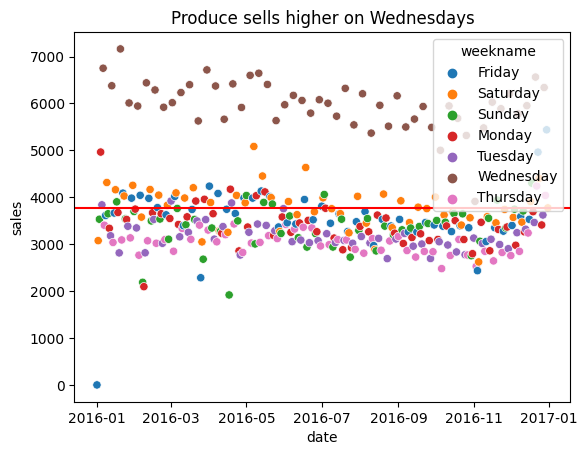

In [7]:
g = train.query('year == 2016')
g = g.query('store_nbr == 24')
# g = g.query('date == "2016-12-01"')
# sns.scatterplot(g, x='date', y=target, hue='store_nbr', palette='Set1');
g = g.query('family == "PRODUCE"')
sns.scatterplot(g, x='date', y=target, hue='weekname')
plt.axhline(g[target].mean(), color='red');
plt.title('Produce sells higher on Wednesdays');

💎There seems to more Produce being sold on Wednesdays.

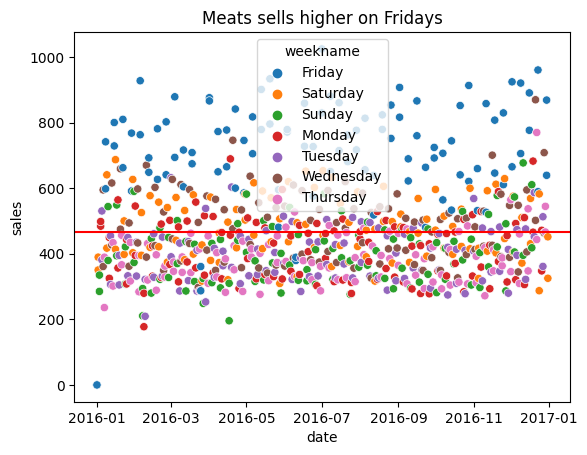

In [8]:
g = train.query('year == 2016')
g = g.query('store_nbr == 24')
# g = g.query('date == "2016-12-01"')
g = g.query('family in ("POULTRY", "MEATS")')
sns.scatterplot(g, x='date', y=target, hue='weekname')
plt.axhline(g[target].mean(), color='red');
plt.title('Meats sells higher on Fridays');


💎Meats sells more on Fridays

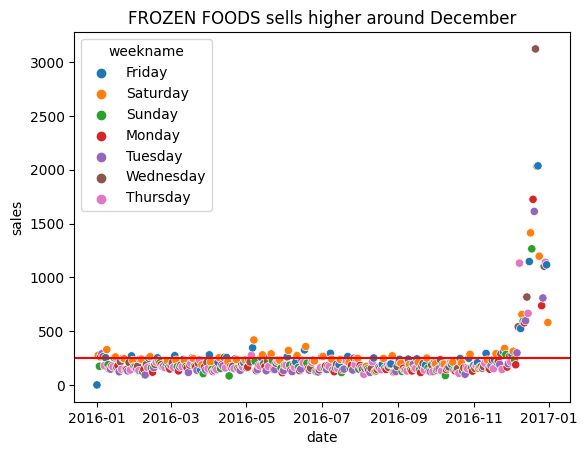

In [9]:
g = train.query('year == 2016')
g = g.query('store_nbr == 24')
# g = g.query('date == "2016-12-01"')
g = g.query('family in ("FROZEN FOODS")')
sns.scatterplot(g, x='date', y=target, hue='weekname')
plt.axhline(g[target].mean(), color='red');
plt.title('FROZEN FOODS sells higher around December');

In [10]:
train.groupby('family')[target].describe().sort_values(by='std')

,count,mean,std,min,25%,50%,75%,max
family,,,,,,,,
BOOKS,78678.0,0.052353,0.529964,0.0,0.00000,0.000000,0.00000,51.000
BABY CARE,78678.0,0.092961,0.676513,0.0,0.00000,0.000000,0.00000,116.000
HOME APPLIANCES,78678.0,0.439869,0.956899,0.0,0.00000,0.000000,1.00000,15.000
HARDWARE,78678.0,1.094563,1.607044,0.0,0.00000,1.000000,2.00000,49.000
BEAUTY,78678.0,3.446732,4.497405,0.0,0.00000,2.000000,5.00000,136.000
MAGAZINES,78678.0,2.381237,5.495999,0.0,0.00000,0.000000,2.00000,79.000
AUTOMOTIVE,78678.0,5.894888,6.202051,0.0,2.00000,4.000000,8.00000,255.000
PET SUPPLIES,78678.0,3.174534,6.808228,0.0,0.00000,0.000000,3.00000,103.000
LAWN AND GARDEN,78678.0,4.371285,7.320915,0.0,0.00000,1.000000,7.00000,201.000


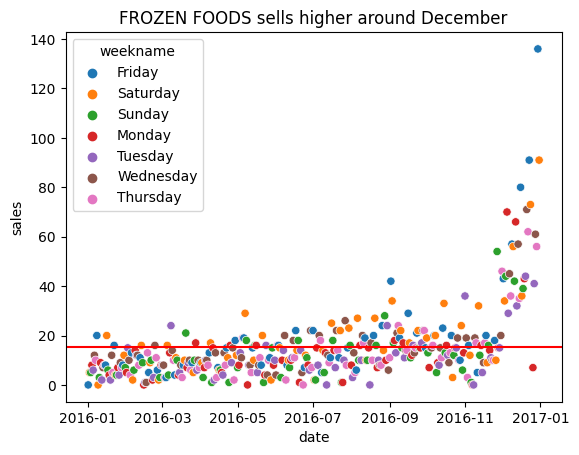

In [11]:
g = train.query('year == 2016')
g = g.query('store_nbr == 24')
# g = g.query('date == "2016-12-01"')
g = g.query('family in ("LAWN AND GARDEN")')
sns.scatterplot(g, x='date', y=target, hue='weekname')
plt.axhline(g[target].mean(), color='red');
plt.title('FROZEN FOODS sells higher around December');

In [12]:
g = train.query('year == 2016')
g = g.query('store_nbr == 24')
g = g.query('family in ("MEATS")')
g = g[['date', 'sales', 'onpromotion', 'weekname']]
# sns.scatterplot(g, x='sales', y='onpromotion')
g['prosale'] = g['onpromotion'] / g['sales']
# g.sort_values(by='prosale', ascending=False)
g.corr(numeric_only=True)

,sales,onpromotion,prosale
sales,1.000000,0.841284,0.744414
onpromotion,0.841284,1.000000,0.968666
prosale,0.744414,0.968666,1.000000


When item is promoted, it get sold more. Around christmas time, the items are naturally sells more without promotion. Promotions takes effect above 200 items. Anything less, it hardly deviates from the average. I think I need to predict 1 type of item at a time then combine the predictions later. If I do 1 model for all types of model, it would just be noisy.
Actions:
- Just focus on Meats, have a marker for about 200 items onpromotion, then add it to the model and see how well it works on a baseline.

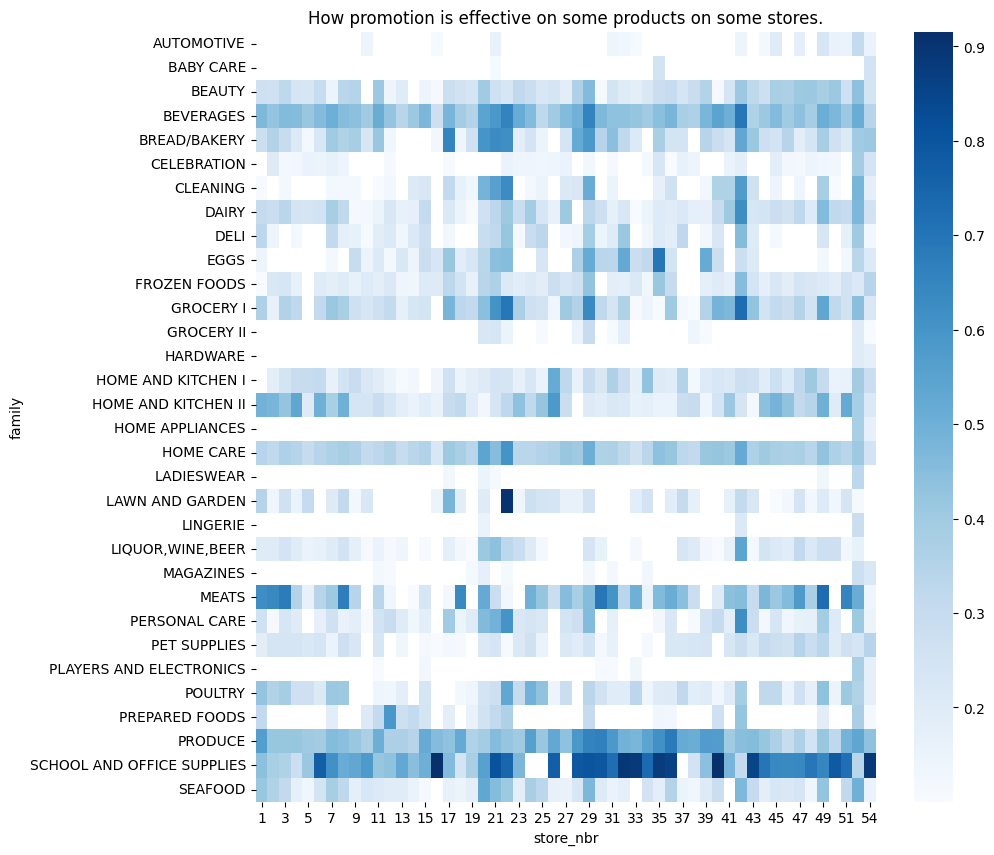

In [13]:
g = train.groupby(['family', 'store_nbr']).corr(numeric_only=True)[target].reset_index()
g = g.query('level_2 == "onpromotion"').dropna(subset='sales')
g = g.sort_values(by='sales')
g = g[g['sales']>0.1]
g = g.pivot_table('sales', index='family', columns='store_nbr', aggfunc='mean')
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(g, cmap='Blues', ax=ax);
plt.title("How promotion is effective on some products on some stores.");

💎Promotion on some products are more effective than others. School and Office supplies is more responsive to promotion.

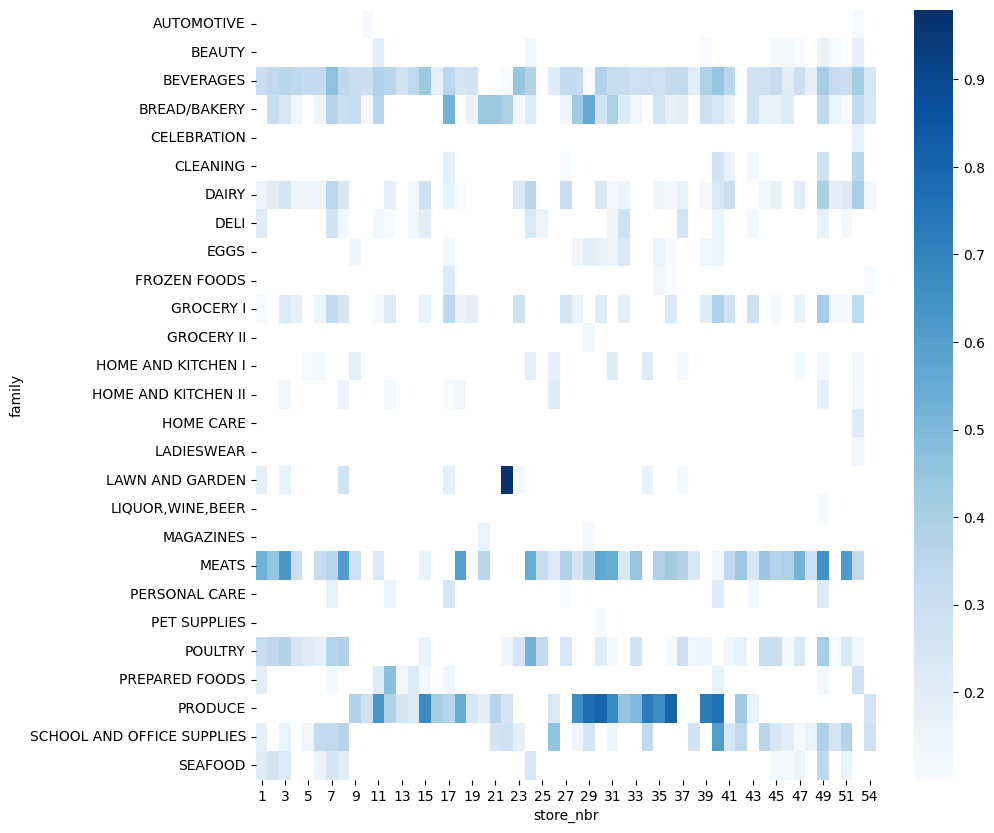

In [14]:
g = train
g['promo-sales'] = train['onpromotion'] / train['sales']
g = g.groupby(['family', 'store_nbr']).corr(numeric_only=True)[target].reset_index()
g = g.query('level_2 == "promo-sales"').dropna(subset='sales')
g = g.sort_values(by='sales')
g = g[g['sales']>0.1]
g = g.pivot_table('sales', index='family', columns='store_nbr', aggfunc='mean')
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(g, cmap='Blues', ax=ax);


# 🤖Model

## Pipes

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

class DataSelect(BaseEstimator, TransformerMixin):
    def __init__(self, att):
        self.att = att
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.att]
    
num_pp = Pipeline([
    ('dataselect', DataSelect(['onpromotion']))
    , ('impute', SimpleImputer(strategy='mean'))
    , ('scaler', StandardScaler())
])

cat_pp = Pipeline([
    ('dataselect', DataSelect(['family', 'store_nbr']))
    , ('encoder', OneHotEncoder(sparse_output=False))
])

pipe = FeatureUnion([
    ('numeric', num_pp)
    , ('cat', cat_pp)
])

pipe.fit(train)
train_pp = pipe.transform(train)
test_pp = pipe.transform(test)

## Baseline

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [17]:
reg_lin = LinearRegression()
reg_lin.fit(train_pp, train[target])
np.sqrt(
    -cross_val_score(
        reg_lin, train_pp, train[target], scoring='neg_mean_squared_error').mean()
)

712.9654122620483

In [18]:
reg_svr = LinearSVR()
reg_svr.fit(train_pp, train[target])
np.sqrt(
    -cross_val_score(
        reg_svr, train_pp, train[target], scoring='neg_mean_squared_error').mean()
)

773.2032253590735

## Submission

In [19]:
samp = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
pd.DataFrame({
    'id': samp['id']
    , 'sales': reg_lin.predict(pipe.transform(samp))
}).to_csv('submission.csv', index=False)

# 📌Notes
- ❓There is something around Sep-Oct for the year 2016. No one is buying stuff for store number 25.
- 💎There seems to more Produce being sold on Wednesdays.
- 💎On Promotion is big factor of selling but it needs to reach a certain threshold to take effect.